# Week 10 - Assignment 12.1

In [43]:
#Exercise 12-1.
#The linear model I used in this chapter has the obvious drawback that it is linear, and
#there is no reason to expect prices to change linearly over time. We can add flexibility
#to the model by adding a quadratic term, as we did in “Nonlinear Relationships” on
#page 133.
#Use a quadratic model to fit the time series of daily prices, and use the model to generate
#predictions. You will have to write a version of RunLinearModel that runs that quadratic
#model, but after that you should be able to reuse code in timeseries.py to generate
#predictions.

In [44]:
import thinkstats2
import thinkplot
import numpy as np
import pandas as pd
import random
import timeseries
import statsmodels.formula.api as smf

In [45]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)

In [46]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/mj-clean.csv")

In [47]:
transactions = pd.read_csv("mj-clean.csv", parse_dates=[5])
transactions 

,city,state,price,amount,quality,date,ppg,state.name,lat,lon
0,Annandale,VA,100,7.075,high,2010-09-02,14.13,Virginia,38.830345,-77.213870
1,Auburn,AL,60,28.300,high,2010-09-02,2.12,Alabama,32.578185,-85.472820
2,Austin,TX,60,28.300,medium,2010-09-02,2.12,Texas,30.326374,-97.771258
3,Belleville,IL,400,28.300,high,2010-09-02,14.13,Illinois,38.532311,-89.983521
4,Boone,NC,55,3.540,high,2010-09-02,15.54,North Carolina,36.217052,-81.687983
...,...,...,...,...,...,...,...,...,...,...
147065,West Palm Beach,FL,140,28.300,high,2014-05-13,4.95,Florida,26.669744,-80.127040
147066,Wilmington,OH,30,3.540,medium,2014-05-13,8.47,Ohio,39.463476,-83.844460
147067,Youngstown,OH,100,10.000,medium,2014-05-13,10.00,Ohio,41.086279,-80.664670
147068,Ypsilanti,MI,35,3.540,medium,2014-05-13,9.89,Michigan,42.235261,-83.607655


In [48]:
data = timeseries.GroupByQualityAndDay(transactions)

In [49]:
def RunQuadraticModel(daily): 
    daily["years2"] = daily.years**2
    model = smf.ols("ppg ~ years + years2", data=daily)
    results = model.fit()
    return model, results

In [50]:
# Solution

name = "high"
daily = data[name]

model, results = RunQuadraticModel(daily) #quadratic model to fit the time series of daily prices
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppg   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     517.5
Date:                Sun, 19 Feb 2023   Prob (F-statistic):          4.57e-164
Time:                        01:29:33   Log-Likelihood:                -1497.4
No. Observations:                1241   AIC:                             3001.
Df Residuals:                    1238   BIC:                             3016.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.6980      0.067    205.757      0.000      13.567      13.829
years         -1.1171      0.084    -13.326      0.000      -1.282      -0.953
years2         0.1132      0.022      5.060      0.000       0.069       0.157
==============================================================================
Omnibus:                       49.112   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.885
Skew:                           0.199   Prob(JB):                     1.86e-25
Kurtosis:                       4.430   Cond. No.                         27.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

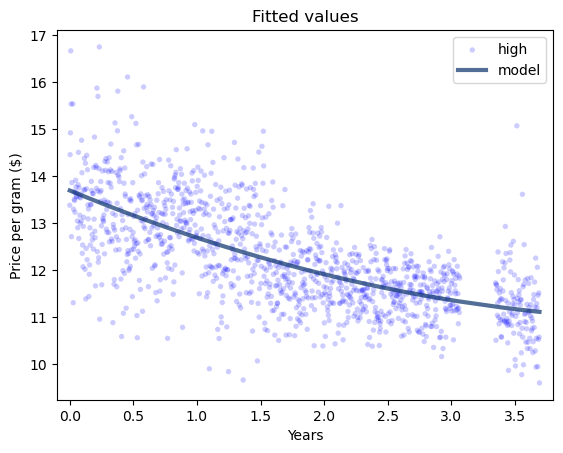

In [51]:
timeseries.PlotFittedValues(model, results,label=name)
thinkplot.Config(title="Fitted values", xlabel="Years", xlim=[-0.1, 3.8], ylabel="Price per gram ($)")

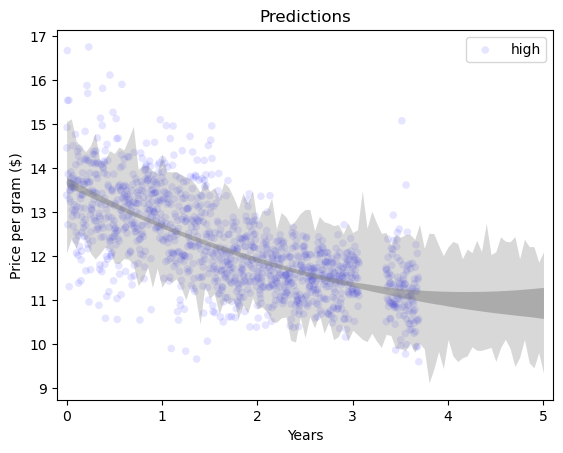

In [52]:
years = np.linspace(0, 5, 101)
thinkplot.Scatter(daily.years, daily.ppg, alpha=0.1, label=name)
timeseries.PlotPredictions(daily, years, func=RunQuadraticModel)
thinkplot.Config(
    title="Predictions",
    xlabel="Years",
    xlim=[years[0] - 0.1, years[-1] + 0.1],
    ylabel="Price per gram ($)",
)

# Week 10 - Assignment 12.2

In [53]:
#Exercise 12-2.
#Write a definition for a class named SerialCorrelationTest that extends
#HypothesisTest from “HypothesisTest” on page 102. It should take a series and a lag
#as data, compute the serial correlation of the series with the given lag, and then compute
#the p-value of the observed correlation.
#Use this class to test whether the serial correlation in raw price data is statistically sig‐
#nificant. Also test the residuals of the linear model and (if you did the previous exercise),
#the quadratic model.

In [54]:
def SerialCorr(series, lag=1):
    xs = series[lag:]
    ys = series.shift(lag)[lag:]
    corr = thinkstats2.Corr(xs, ys)
    return corr

In [55]:
class SerialCorrelationTest(thinkstats2.HypothesisTest): 

    def TestStatistic(self, data): 
        series, lag = data
        test_stat = abs(SerialCorr(series, lag))
        return test_stat

    def RunModel(self): 
        series, lag = self.data
        permutation = series.reindex(np.random.permutation(series.index))
        return permutation, lag

In [56]:
name = "high"
daily = data[name]

series = daily.ppg
test = SerialCorrelationTest((series, 1)) # serial correlation of the series with the given lag = 1
pvalue = test.PValue() #p-value of the observed correlation
test.actual, pvalue

(0.4852293761947381, 0.0)

In [57]:
#Residuals of the Linear Model
_, results = timeseries.RunLinearModel(daily)
series = results.resid
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
test.actual, pvalue

(0.07570473767506262, 0.008)

In [58]:
#Residuals of the quadratic model
_, results = RunQuadraticModel(daily)
series = results.resid
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
test.actual, pvalue

(0.056073081612899166, 0.048)